# Визуализация количества статей с упоминанием ключевых слов

Используются данные по статьям с ресурсов habrahabr.ru и geektimes.ru. В каждой статье производится поиск ключевых слов. Строится визуализация количества статей на указанную тематику и их % от общего числа статей.

Ссылка на kaggle с учебным конкурсом: https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm


### Подключить библиотеки

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Импортировать и подготовить данные

In [3]:
# Импорт данных
data_train = pd.read_csv('howpop_train.csv')
data_test = pd.read_csv('howpop_test.csv')

# Объединить данные
data = pd.concat([data_train, data_test], axis=0, ignore_index=True)

print('Исходная размерность данных', data_train.shape, data_test.shape, data.shape)

# Время публикации к типу Datetime
data['published']=pd.to_datetime(data['published'])

# Создать столбец годмесяц
data['year_month'] = data['published'].dt.year*100 + data['published'].dt.month
data.head(5)

Исходная размерность данных  (134137, 17) (3990, 9) (138127, 17)


,author,comments,comments_lognorm,content_len,domain,favs,favs_lognorm,flow,polling,post_id,published,title,url,views,views_lognorm,votes_minus,votes_plus,year_month
0,@Tapac,0.0,-2.436871,4305,habrahabr.ru,0.0,-1.344075,develop,False,18284,2008-01-01 18:19:00,Новогодний подарок блоггерам — WordPress 2.3.2,https://habrahabr.ru/post/18284/,236.0,-0.792687,0.0,0.0,200801
1,@DezmASter,1.0,-1.873193,7344,habrahabr.ru,1.0,-0.831946,design,False,18285,2008-01-01 18:30:00,"Сумасшедшие яйца, или сервис для отслеживания ...",https://habrahabr.ru/post/18285/,353.0,-0.485214,0.0,1.0,200801
2,@DezmASter,47.0,0.574656,8431,habrahabr.ru,72.0,1.794023,design,False,18286,2008-01-01 18:34:00,"Сумасшедшие яйца, или сервис для отслеживания ...",https://habrahabr.ru/post/18286/,1200.0,0.446090,5.0,45.0,200801
3,@Taoorus,102.0,1.167375,5662,habrahabr.ru,36.0,1.300050,design,False,18291,2008-01-02 01:32:00,"Сглаживание шрифтов, и субпиксельная отрисовка",https://habrahabr.ru/post/18291/,5700.0,1.627469,3.0,72.0,200801
4,@dennydo,230.0,2.020356,3706,geektimes.ru,6.0,0.961094,NaN,False,18294,2008-01-02 14:34:00,Почему мне не нравится iPhone,https://geektimes.ru/post/18294/,1400.0,1.362397,15.0,73.0,200801


## Импортирование данных json и проверка вхождения слов в статью

In [5]:
import jsonlines
from bs4 import BeautifulSoup

list_of_ml = ['машинное обучение', 
              'машинного обучения', 
              'машинному обучению', 
              'машинном обучени',
              'machine learning', 
              'machines learning']
list_of_nn = ['нейронные сети',
              'нейронную сеть', 
              'нейронных сетей', 
              'neural network', 
              'нейросет']
list_of_ds = ['data science', 
              'дата сайенс', 
              'датасайнтист', 
              'датасайенс',
              'датасаенс'
             ]

data_ml = []
data_nn = []
data_ds = []

# Поиск в данных для train
reader = jsonlines.open('howpop_train.jsonlines')
for obj in reader:
    
    text_data = BeautifulSoup(obj['content'], "lxml").get_text().lower()
    
    founded = False
    for word in list_of_ml:
        founded = founded | (word in text_data)
    data_ml.append(founded)
    
    founded = False
    for word in list_of_nn:
        founded = founded | (word in text_data)
    data_nn.append(founded)
    
    founded = False
    for word in list_of_ds:
        founded = founded | (word in text_data)
    data_ds.append(founded)
reader.close()

# Поиск в данных для test
reader = jsonlines.open('howpop_test.jsonlines')
for obj in reader:
    
    text_data = BeautifulSoup(obj['content'], "lxml").get_text().lower()
    
    founded = False
    for word in list_of_ml:
        founded = founded | (word in text_data)
    data_ml.append(founded)
    
    founded = False
    for word in list_of_nn:
        founded = founded | (word in text_data)
    data_nn.append(founded)
    
    founded = False
    for word in list_of_ds:
        founded = founded | (word in text_data)
    data_ds.append(founded)
reader.close()

In [ ]:
#Посмотреть содержимое одного объекта из массива jsonlines, удалив теги
BeautifulSoup(obj['content'], "lxml").get_text().lower()

### Добавить признак принадлежности статьи к одной из категории

In [6]:
# Столбец присутствуют ли искомые слова в статьях
data['is_ml'] = list(map(int,data_ml))
data['is_nn'] = list(map(int,data_nn))
data['is_ds'] = list(map(int,data_ds))

# Составить данные по популярности искомых слов для каждого месяца
data_pop = data.groupby('year_month')[['is_ml', 'is_nn', 'is_ds']].sum()

# Количество статей в каждом месяце
num_articles = data['year_month'].value_counts().sort_index()

# Популярность в процентах от всех статей
data_pop_perc = data_pop.div(num_articles, axis='index')*100

### Визуализация

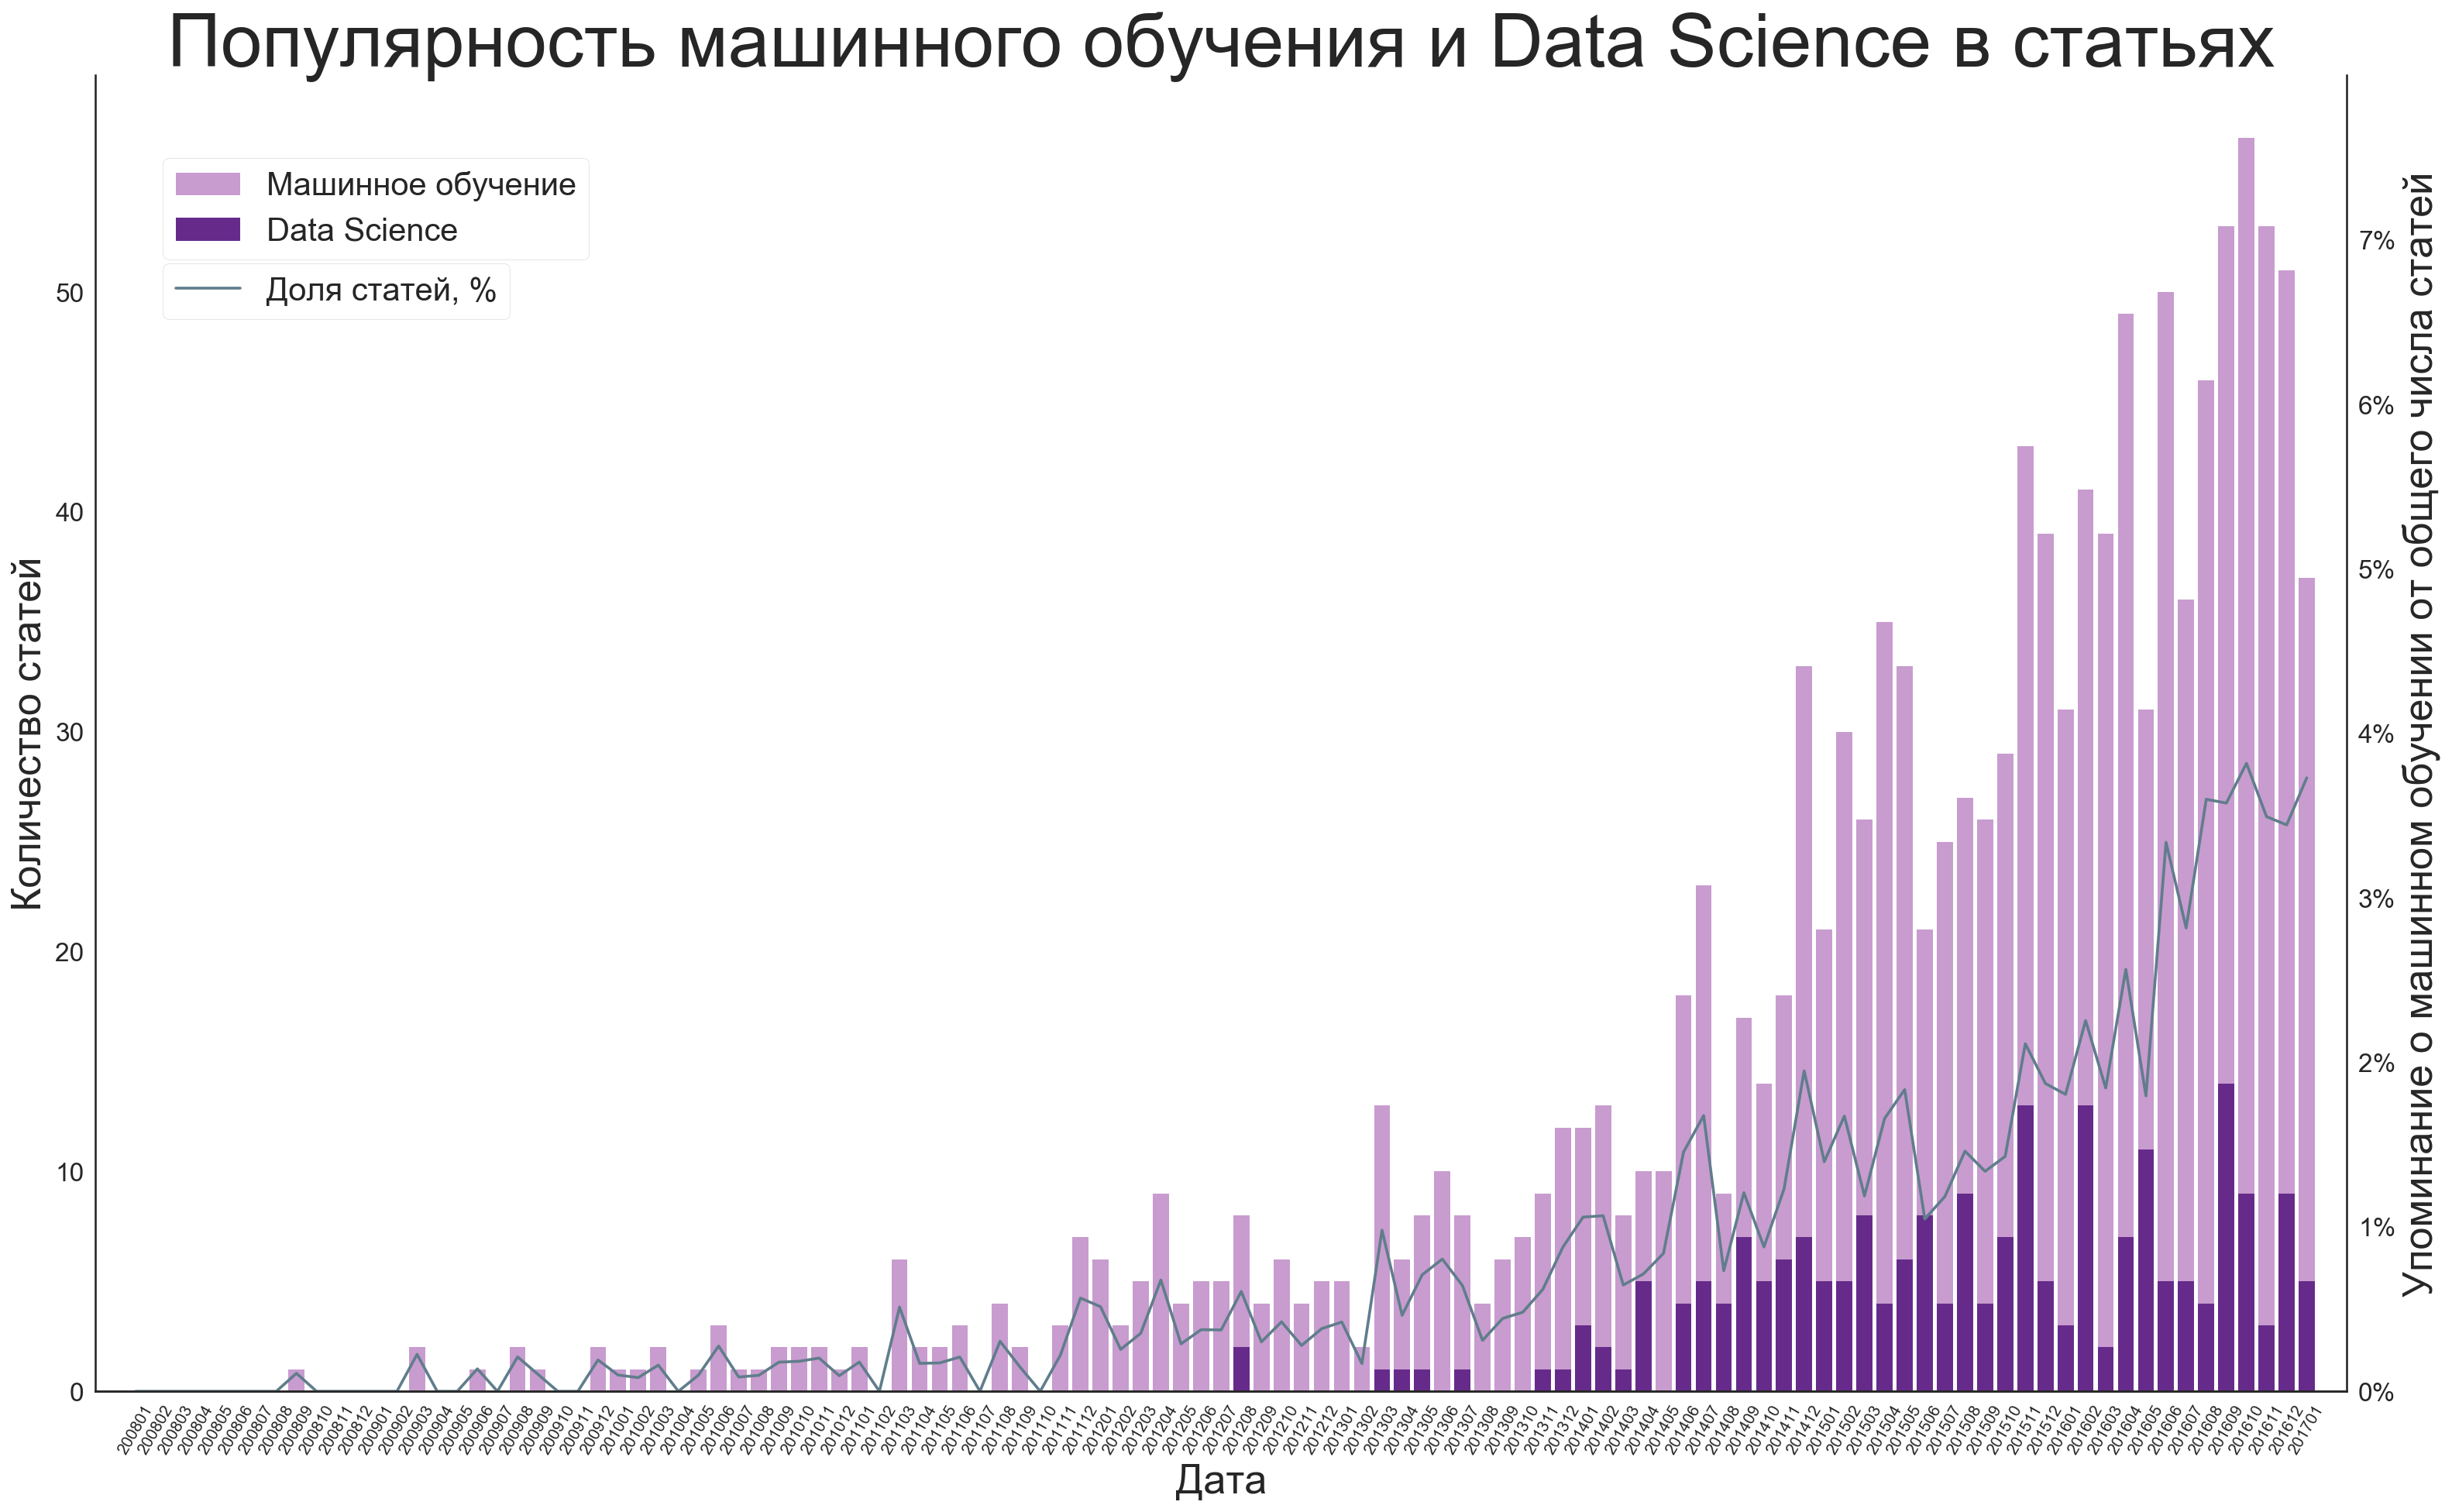

In [8]:
sns.set(style="white")

f, ax = plt.subplots(figsize=(25, 15), dpi=150)

# Машинное обучение
sns.set_color_codes("pastel")
sns.barplot(ax=ax, x=data_pop.index.astype('str'), y='is_ml', data=data_pop, 
            label="Машинное обучение", 
            color="#CE93D8")

# Количество Data Science
sns.set_color_codes("muted")
sns.barplot(ax=ax, x=data_pop.index.astype('str'), y="is_ds", data=data_pop, 
            label="Data Science", 
            color="#6A1B9A")

plt.xticks(rotation=60);

ax2 = ax.twinx()
ax2.plot(data_pop_perc['is_ml'].values, '#607D8B', label='Доля статей, %')

# Настройка axes с bar
ax.legend(ncol=1, loc=(0.03,0.86),frameon=True, fontsize=20)
ax.axes.set_title('Популярность машинного обучения и Data Science в статьях', fontsize=46, verticalalignment='baseline')
ax.set_xlabel('Дата', fontsize=25)
ax.set_ylabel('Количество статей', fontsize=25)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlim([-2, 110])

# Настройка axes with plot
ax2.legend(loc=[0.03, 0.815], frameon=True, fontsize=20)
ax2.set_ylabel('Упоминание о машинном обучении от общего числа статей')
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylim([0,8])
ax2.yaxis.label.set_size(25)

# Установить проценты правой шкалы
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0f}%'.format(x) for x in vals[:8]])

sns.despine(ax=ax, left=False, right=True, top=True)
sns.despine(ax=ax2, left=True, right=False, top=True)

# Сохранить
f.savefig("popularity_ml.jpg", bbox_inches='tight', pad_inches=0.6)